# Inter-Maimi - PROD Retention Score
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* June 20, 2022

In [1]:
import getpass
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from pycaret.classification import *

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [mlsInterMiami].[ds].[getRetentionScoringModelData] 113 """
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(6938, 17)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6938 entries, 0 to 6937
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dimCustomerMasterId  6938 non-null   int64  
 1   year                 6938 non-null   int64  
 2   productGrouping      6938 non-null   object 
 3   email                6899 non-null   object 
 4   ticketingid          6938 non-null   object 
 5   totalSpent           6938 non-null   float64
 6   recentDate           6938 non-null   object 
 7   attendancePercent    6938 non-null   float64
 8   renewedBeforeDays    6938 non-null   int64  
 9   source_tenure        6938 non-null   int64  
 10  tenure               6938 non-null   int64  
 11  distToVenue          6685 non-null   float64
 12  recency              6938 non-null   int64  
 13  missed_games_1       6938 non-null   int64  
 14  missed_games_2       6938 non-null   int64  
 15  missed_games_over_2  6938 non-null   i

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = [
            "dimCustomerMasterId",
            "email",
            "ticketingid",
            "year",
            "productGrouping", 
            "totalSpent", 
            "recentDate",
            "attendancePercent", 
            "renewedBeforeDays",
            "source_tenure",
            "tenure",
            "distToVenue",
            "recency",
            "missed_games_1",
            "missed_games_2",
            "missed_games_over_2",
            "isNextYear_Buyer"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2021]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (3599, 17)
Unseen Data For Predictions: (635, 17)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","email","productGrouping","ticketingid","year"],
    silent=True,
    verbose=False,
    numeric_features=[
    "totalSpent", 
            "attendancePercent", 
            "renewedBeforeDays",
            "source_tenure",
            "tenure",
            "distToVenue",
            "recency",
            "missed_games_1",
            "missed_games_2",
            "missed_games_over_2"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lightgbm"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.6257,0.7019,0.6606,0.6078,0.6327,0.2524,0.2538,0.8120


In [8]:
lightgbm_model = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6275,0.6694,0.6779,0.6048,0.6392,0.2567,0.2585
1,0.6405,0.7062,0.6913,0.6168,0.6519,0.2828,0.2847
2,0.6667,0.7486,0.6711,0.6536,0.6623,0.3333,0.3334
3,0.6209,0.7103,0.6309,0.6065,0.6184,0.2421,0.2423
4,0.6209,0.6881,0.6174,0.6093,0.6133,0.2416,0.2416
5,0.6078,0.6811,0.6267,0.5949,0.6104,0.2162,0.2165
6,0.6242,0.7215,0.7200,0.5967,0.6526,0.2511,0.2563
7,0.6046,0.6865,0.6733,0.5838,0.6254,0.2112,0.2136
8,0.6111,0.6901,0.6200,0.6000,0.6098,0.2224,0.2225
9,0.6328,0.7175,0.6779,0.6121,0.6433,0.2670,0.2684


### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2022]
df_inference = df_inference.fillna(0)
df_inference.shape

(2704, 17)

In [10]:
lightgbm_predictions = predict_model(lightgbm_model, data=df_inference, raw_score=True)

In [11]:
print(f"lightgbm:\n {lightgbm_predictions.Label.value_counts()}")

lightgbm:
 0    1922
1     782
Name: Label, dtype: int64


In [12]:
print(f"lightgbm:\n {lightgbm_predictions.Score_1.value_counts(bins=[0, 0.25, 0.5, 0.75, 1])}")

lightgbm:
 (-0.001, 0.25]    985
(0.25, 0.5]       937
(0.5, 0.75]       549
(0.75, 1.0]       233
Name: Score_1, dtype: int64


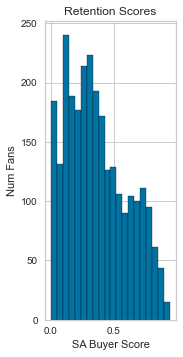

In [13]:
model_predictions = [lightgbm_predictions]

for idx, df_predictions in enumerate(model_predictions):

    plt.subplot(1, 3, idx+1)

    plt.hist(df_predictions["Score_1"], bins=20, edgecolor='black')
    plt.title("Retention Scores")
    plt.ylabel("Num Fans")
    plt.xlabel("SA Buyer Score")

plt.rcParams["figure.figsize"] = (20,4)
plt.show()

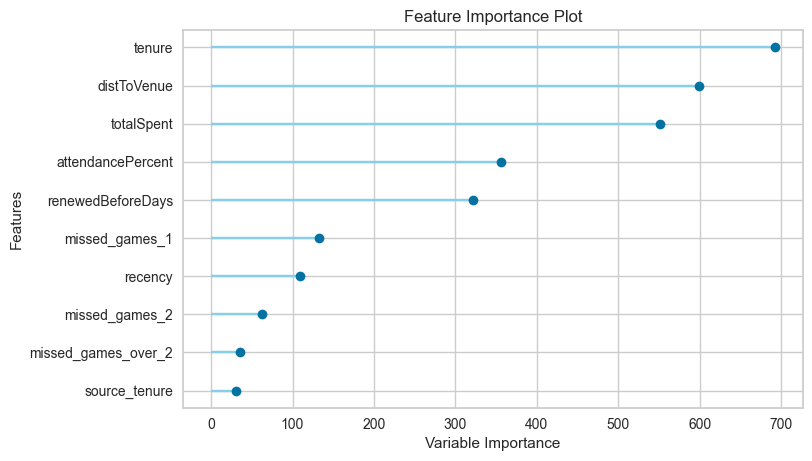

In [14]:
plot_model(lightgbm_model, plot='feature')

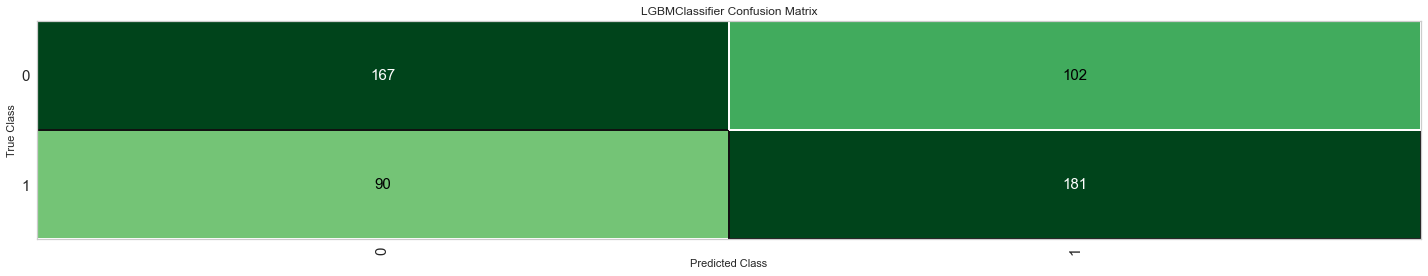

In [15]:
plot_model(lightgbm_model, plot='confusion_matrix')

In [16]:
lightgbm_predictions

,dimCustomerMasterId,year,productGrouping,email,ticketingid,totalSpent,recentDate,attendancePercent,renewedBeforeDays,source_tenure,tenure,distToVenue,recency,missed_games_1,missed_games_2,missed_games_over_2,isNextYear_Buyer,Label,Score_0,Score_1
0,46,2022,Flex Plan,195cleanup@gmail.com,270764,312.0,2022-07-13,0.88,10,730,150,38.20,0,0,0,0,0,0,0.9814,0.0186
4,121,2022,Full Season,6XIIRT@GMAIL.COM,277117,875.5,2022-08-20,0.62,159,730,950,57.52,0,2,2,0,0,0,0.5113,0.4887
6,157,2022,Full Season,a.davitkov@yahoo.com,129436,850.0,2022-08-20,0.85,33,1095,1095,17.84,0,3,0,0,0,0,0.7196,0.2804
10,246,2022,Full Season,aamarin999@hotmail.com,131585,2276.3,2022-08-13,0.73,101,1095,1094,12.75,0,0,0,1,0,0,0.5685,0.4315
12,282,2022,Full Season,aaronjoseph55@gmail.com,123961,1575.9,2022-08-20,0.81,100,1095,1094,2.83,0,3,0,0,0,0,0.7325,0.2675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6929,2565499,2022,Full Season,yalouri@yahoo.com,140976,1575.9,1970-01-01,0.00,162,1095,1068,9.54,0,0,0,1,0,0,0.7917,0.2083
6931,2565947,2022,Full Season,yons.sturmwind@gmail.com,271908,2626.5,2022-08-20,0.91,159,730,955,24.84,0,1,0,0,0,0,0.6778,0.3222
6933,2566085,2022,Full Season,eng1067@hotmail.com,403665,1575.9,1970-01-01,0.00,162,730,737,59.13,0,0,0,1,0,0,0.7636,0.2364
6935,2566232,2022,Full Season,zgreer.33@gmail.com,142673,2125.0,2022-08-20,0.77,100,1095,1061,23.21,0,4,0,0,0,0,0.6335,0.3665


In [20]:
current_date = datetime.today().strftime('%Y-%m-%d')
lightgbm_predictions.to_json(f"Results/InterMiami_Retention_Scores_{current_date}.csv.out", orient="records")